In [1]:
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import sklearn.cluster
import sklearn.decomposition
import pickle
import sklearn.neighbors
import sklearn.linear_model

import fmEphys

DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


In [152]:
plasma_map = plt.cm.plasma(np.linspace(0,1,15))
colors = {
    'movement': plasma_map[12,:],
    'early': plasma_map[10,:],
    'late': plasma_map[8,:],
    'biphasic': plasma_map[5,:],
    'negative': plasma_map[2,:],
    'unresponsive': 'dimgrey',
    'gaze': 'firebrick',
    'comp': 'mediumblue',
    'rc': 'indigo'
}
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams.update({'font.size':10})
%matplotlib inline

# funcs

In [84]:
def z_score(A):
    return (np.max(np.abs(A))-np.mean(A)) / np.std(A)

def calc_PSTH_latency(psth):
    """
    use normalized PSTH
    """
    psth_bins = np.arange(-1,1.001,1/1000)

    ind = np.argmax(psth[1025:1250]) + 1025

    peakT = psth_bins[ind]
    
    val = psth[ind]
    
    return peakT, val

def calc_PSTH_modind(psth, baseval='range'):
    # modulation in terms of spike rate
    psth = psth.astype(float)
    if baseval=='range':
        use = psth - np.mean(psth[0:800].copy())
    elif baseval=='zero':
        use = psth - psth[1000]
    elif baseval=='tight':
        use = psth - np.mean(psth[750:975].copy())
    mod = np.max(np.abs(use[1000:1250]))
    return mod

def calc_PSTH_DS(left, right):
    # use raw PSTH
    
    leftmod = calc_PSTH_modind(left)
    rightmod = calc_PSTH_modind(right)

    ind = np.argmax([leftmod, rightmod])
    
    pref = [left, right][ind]
    nonpref = [left, right][1-ind]
    
    prefname = ['left','right'][ind]
    nonprefname = ['left','right'][1-ind]
    
    return pref, nonpref, prefname, nonprefname


def calc_PSTH_DSI(pref, nonpref):
    # use pref
    
    prefmod = calc_PSTH_modind(pref)
    nonprefmod = calc_PSTH_modind(nonpref)
    
    mod = (prefmod - nonprefmod) / (prefmod + nonprefmod)
    
    return mod
    
def norm_PSTH(psth, raw_pref=None, baseline_val='zero'):
    
    if raw_pref is None:
        raw_pref = psth.copy()

    if baseline_val is None:
        baseline_val = np.mean(psth[0:800].astype(float))
        
    if baseline_val == 'zero':
        baseline_val = psth[1000]
        
    if baseline_val == 'tight':
        baseline_val = np.mean(psth[750:975].astype(float))
        
    if baseline_val == 'tight1':
        baseline_val = np.mean(psth[850:1000].astype(float))
        
    
    norm_psth = (psth - baseline_val) / np.max(raw_pref[750:1250].astype(float))
    
    return norm_psth

def drop_nan_along(x, axis=1):
    # axis=1 will drop along columns (i.e. any rows with NaNs will be dropped)
    x = x[~np.isnan(x).any(axis=axis)]
    return x

def add_stimuli_horizontally(df_list):
    session = pd.DataFrame([])
    for r in df_list:
        
        # get column names
        column_names = list(session.columns.values) + list(r.columns.values)
        
        # new columns for same unit within a session
        session = pd.concat([session, r], axis=1, ignore_index=True)
        
        # add the list of column names from all sessions plus the current recording
        session.columns = column_names
        
        # remove duplicate columns (i.e. shared metadata)
        session = session.loc[:, ~session.columns.duplicated()]
        
    return session

def add_sessions_vertically(df_list, savepath=None):
    
    dataset = pd.concat(df_list, axis=0)
    # Reset unit numbers
    dataset.reset_index(inplace=True, drop=True)

    return dataset

def calc_kde_PSTH(spikeT, eventT, bandwidth=10, resample_size=1, edgedrop=15, win=1000):
    # Unit conversions
    bandwidth = bandwidth / 1000
    resample_size = resample_size / 1000
    win = win / 1000
    edgedrop = edgedrop / 1000
    edgedrop_ind = int(edgedrop / resample_size)

    bins = np.arange(-win-edgedrop, win+edgedrop+resample_size, resample_size)

    # Timestamps of spikes (`sps`) relative to `eventT`
    sps = []
    for i, t in enumerate(eventT):
        sp = spikeT-t
        # Only keep spikes in this window
        sp = sp[(sp <= (win+edgedrop)) & (sp >= (-win-edgedrop))] 
        sps.extend(sp)
    sps = np.array(sps)

    if len(sps) < 10:
        n_bins = int((win * 1000 * 2) + 1)
        return np.zeros(n_bins)*np.nan

    kernel = sklearn.neighbors.KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(sps[:, np.newaxis])
    density = kernel.score_samples(bins[:, np.newaxis])

    # Multiply by the # spikes to get spike count per point. Divide
    # by # events for rate/event.
    psth = np.exp(density) * (np.size(sps ) / np.size(eventT))

    # Drop padding at start & end to eliminate edge effects.
    psth = psth[edgedrop_ind:-edgedrop_ind]

    return psth

# create the dataset

In [6]:
recording_directories = [
    '/home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/041422/J599RT', # 1
    '/home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/041422/J593LT', # 2
    '/home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/041822/J594NC', #3
    '/home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/042022/J604RT', # 5
    '/home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/042122/J604RT', # 6
    '/home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/042222/J594RT', # 7
    '/home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/042322/J559NC', # 8
    # '/home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/050522/G6CK5BRN', # 10
    '/home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/050622/J606NC', # 11
    '/home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/060822/J611RN',
    '/home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/060922/J611RN'
]

name_opts = {
    'hf1_revchecker500ms': 'Rc',
    'hf2_sparsenoiseflash500msISI': 'SnI',
    'hf5_sparsenoiseflash500ms': 'Sn',
    'hf2_sparseflash': 'Sn',
    'hf2_sparsenoiseflash': 'Sn',
    'hf5_sparseflash': 'Sn',
    'hf4_sparsenoiseflashRAND': 'SnR',
    'hf3_sparsenoiseflashRAND': 'SnR',
    'hf1_revchecker': 'Rc',
    'hf2_sparseflashgray': 'SnI'
}

sess_df_list = []

for recpath in tqdm(recording_directories):

    subdirs = fmEphys.list_subdirs(recpath, givepath=True)
    subdirs = [p for p in subdirs if any(s in p for s in list(name_opts.keys()))]

    stim_df_list = []

    for sd in subdirs:
        
        full_stim_label = os.path.split(sd)[1]
        h5_path = fmEphys.find('*ephys_props.h5', sd)
        if len(h5_path) > 0:
            h5_path = fmEphys.filter_file_search(h5_path, MR=True)
        else:
            print('No file for ', recpath, full_stim_label)
            continue
        # print(h5_path)
        
        try:
            df = pd.read_hdf(h5_path)
        except AttributeError:
            print('-> Error reading: ', h5_path)
            continue

        # Change recording prefix (set in dict `name_opts`)
        newcols = []
        for c in list(df.columns):
            if c=='session':
                newcols.append(c)
            else:
                if (df['session'].iloc[0]=='041422_J593LT_control_Rig2') & (name_opts[full_stim_label]=='Sn'):
                    _use_label = 'SnI'
                else:
                    _use_label = name_opts[full_stim_label]
                newcols.append(c.replace(c[:2], _use_label))

        df.columns = newcols

        stim_df_list.append(df)

    all_stim = add_stimuli_horizontally(stim_df_list)
    
    sess_df_list.append(all_stim)
    
flhf = add_sessions_vertically(sess_df_list)

fmEphys.write_group_h5(flhf, '/home/niell_lab/Data/freely_moving_ephys/batch_files/013023/flhf_013123_v5.h5')

 60%|███████████████████████████████████████████████████████▏                                    | 6/10 [00:13<00:08,  2.09s/it]

-> Error reading:  /home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/042322/J559NC/hf2_sparseflashgray/042322_J559NC_control_Rig2_hf2_sparseflashgray_ephys_props.h5


 70%|████████████████████████████████████████████████████████████████▍                           | 7/10 [00:14<00:05,  1.79s/it]

-> Error reading:  /home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/042322/J559NC/hf5_sparseflash/042322_J559NC_control_Rig2_hf5_sparseflash_ephys_props.h5
-> Error reading:  /home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/050622/J606NC/hf2_sparseflashgray/050622_J606NC_control_Rig2_hf2_sparseflashgray_ephys_props.h5


 80%|█████████████████████████████████████████████████████████████████████████▌                  | 8/10 [00:15<00:03,  1.66s/it]

-> Error reading:  /home/niell_lab/Mounts/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/050622/J606NC/hf5_sparseflash/050622_J606NC_control_Rig2_hf5_sparseflash_ephys_props.h5


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


# or read the data from a file

In [4]:
flhf = fmEphys.read_group_h5('/home/niell_lab/Data/freely_moving_ephys/batch_files/013023/flhf_013123_v5.h5')

In [164]:
fmEphys.write_group_h5(flhf, '/home/niell_lab/Data/freely_moving_ephys/batch_files/013023/flhf_021623_recalcPSTHs.h5')

# recalc PSTHs

In [5]:
# does this stimulus exist for a given recording?
for x in [x for x in flhf.columns.values if '_eyeT' in x]:
    stim = (x.split('_'))[0]
    flhf['has'+stim] = False
    for ind, row in flhf.iterrows():
        if not np.isnan(row[x]).all():
            flhf.at[ind,'has'+stim] = True

## has ISI

In [6]:
# for ind, row in flhf['hasSnR'].iterrows():
tmp_arr = np.zeros(2001)*np.nan
tmp_series = pd.Series([])
for i in range(len(flhf.index.values)):
    tmp_series.at[i] = tmp_arr.astype(object)
flhf['SnI_recalc_stim_psth'] = tmp_series.copy()

for s in flhf['session'][flhf['hasSnI']].unique():
    row = flhf[flhf['session']==s].iloc[0].copy()
    
    stim_time = row['SnI_worldT']
    stimcontrast = row['SnI_contrast']
    
    stim_on = np.diff((stimcontrast>0.25))==1
    
    _arr_test = np.diff(np.diff(stimcontrast)>0.2)
    _new_arr = []
    for i in range(_arr_test.size):
        if (_arr_test[i-1]==True) and (_arr_test[i]==True):
            _new_arr.append(True)
        else:
            _new_arr.append(False)

    stim_onset_times = row['SnI_worldT'][:-2][_new_arr]
    
    for ind, row in tqdm(flhf[flhf['session']==s][flhf['hasSnI']].iterrows()):
        sps = row['SnI_spikeT']
        
        flhf.at[ind, 'SnI_recalc_stim_psth'] = calc_kde_PSTH(sps, stim_onset_times).astype(object)
    

84it [00:04, 19.39it/s]
80it [00:13,  5.74it/s]
187it [00:08, 23.29it/s]
16it [00:01, 10.11it/s]
61it [00:03, 19.06it/s]


## no ISI

In [7]:
# for ind, row in flhf['hasSnR'].iterrows():
tmp_arr = np.zeros(2001)*np.nan
tmp_series = pd.Series([])
for i in range(len(flhf.index.values)):
    tmp_series.at[i] = tmp_arr.astype(object)
flhf['Sn_recalc_stim_psth'] = tmp_series.copy()

for s in flhf['session'][flhf['hasSn']].unique()[1:]:
    row = flhf[flhf['session']==s].iloc[0].copy()
    
    stim_time = row['Sn_worldT']
    stimcontrast = row['Sn_contrast']
    
    stim_on = np.diff((stimcontrast>0.25))==1
    
    _arr_test = np.abs(np.diff(stimcontrast))>0.05
    _new_arr = []
    for i in range(_arr_test.size):
        if (_arr_test[i-1]==True) and (_arr_test[i]==True):
            _new_arr.append(True)
        else:
            _new_arr.append(False)

    stim_onset_times = row['Sn_worldT'][:-1][_new_arr]
    
    for ind, row in tqdm(flhf[flhf['session']==s][flhf['hasSn']].iterrows()):
        sps = row['Sn_spikeT']
        
        flhf.at[ind, 'Sn_recalc_stim_psth'] = calc_kde_PSTH(sps, stim_onset_times).astype(object)
    

187it [00:51,  3.63it/s]
16it [00:03,  4.76it/s]
17it [00:06,  2.59it/s]
61it [00:21,  2.87it/s]
74it [00:17,  4.33it/s]
82it [00:21,  3.75it/s]


# normalize

In [85]:
# normalize PSTHs
psth_keys = {
    'Rc_stim_PSTH': 'Rc_norm_psth',
    'Rc_stim_PSTH': 'Rc_norm_psth',
    'SnI_recalc_stim_psth': 'SnI_norm_psth',
    'Sn_recalc_stim_psth': 'Sn_norm_psth',
    'SnR_stim_PSTH_onSub_bckgndRF': 'SnR_norm_psth'
}
check_has_keys = {
    'Rc_norm_psth': 'hasRc',
    'SnI_norm_psth': 'hasSnI',
    'Sn_norm_psth': 'hasSn',
    'SnR_norm_psth': 'hasSnR'
}
tmp_arr = np.zeros(2001)*np.nan
tmp_series = pd.Series([])
for i in range(len(flhf.index.values)):
    tmp_series.at[i] = tmp_arr.astype(object)
for x in psth_keys.values():
    flhf[x] = tmp_series.copy()

for ind, row in tqdm(flhf.iterrows()):
    for key, newcol in psth_keys.items():
        if type(row[key]) != float:
            flhf.at[ind, newcol] = norm_PSTH(row[key])

667it [00:00, 1763.63it/s]


# responsive to stimulus?

In [86]:
def check_stim_responsive(df, raw_psth_key, stim):
    
    has_key = 'has{}'.format(stim)
    eye_key = '{}_eyeT'.format(stim)
    spike_key = '{}_spikeT'.format(stim)
    fr_key = '{}_fr'.format(stim)
    norm_psth_key = '{}_norm_psth'.format(stim)
    
    for ind, row in df[df[has_key]].iterrows():
        sec = row[eye_key][-1].astype(float) - row[eye_key][0].astype(float)
        sp = len(row[spike_key])
        df.at[ind, fr_key] = sp/sec

        df.at[ind, 'raw_mod_for_{}'.format(stim)] = calc_PSTH_modind(row[raw_psth_key], baseval='zero')

        df.at[ind, 'norm_mod_for_{}'.format(stim)] = calc_PSTH_modind(row[norm_psth_key], baseval='zero')
    
    df['{}_responsive'.format(stim)] = False
    for ind, row in df[df['has{}'.format(stim)]].iterrows():
        if (row['raw_mod_for_{}'.format(stim)]>1) and (row['norm_mod_for_{}'.format(stim)]>0.1):
            df.at[ind, '{}_responsive'.format(stim)] = True
    # print(df['{}_responsive'.format(stim)].sum(), '/', len(df.index))
    
    return df

flhf = check_stim_responsive(flhf, 'Rc_stim_PSTH', 'Rc')
flhf = check_stim_responsive(flhf, 'SnI_recalc_stim_psth', 'SnI')
flhf = check_stim_responsive(flhf, 'Sn_recalc_stim_psth', 'Sn')



# cluster

using best 4 PCs


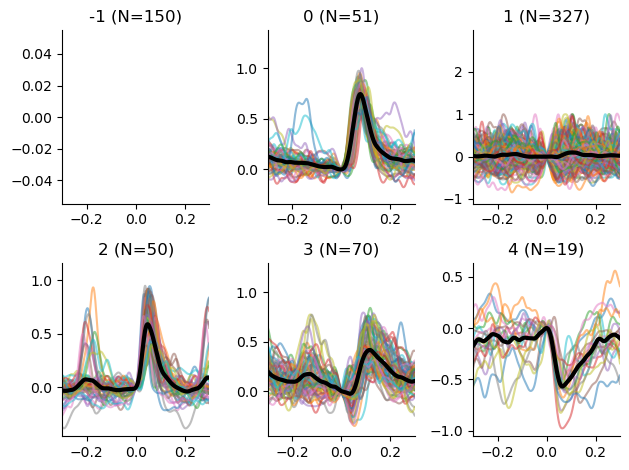

In [112]:
pca_input = np.zeros([len(flhf[flhf['hasSn']].index), 350])*np.nan

for i, ind in enumerate(flhf[flhf['hasSn']].index.values):
    
    if flhf.loc[ind, 'Sn_responsive'] == True:
        pca_input[i,:] = flhf.loc[ind, 'Sn_norm_psth'][950:1300]
    
    elif flhf.loc[ind, 'Sn_responsive'] == False:
        pca_input[i,:] = np.zeros(350)

n_pcas = 10
req_explvar=0.95

pca = sklearn.decomposition.PCA(n_components=n_pcas)
pca.fit(pca_input)

explvar = pca.explained_variance_ratio_

proj = pca.transform(pca_input)

keep_pcas = int(np.argwhere(np.cumsum(explvar)>req_explvar)[0])
print('using best {} PCs'.format(keep_pcas))

gproj = proj[:,:keep_pcas]

km = sklearn.cluster.KMeans(n_clusters=5)
km.fit_predict(gproj)
Z = km.labels_

flhf['Sncluster_ind'] = -1
for i, ind in enumerate(flhf[flhf['hasSn']].index.values):
    flhf.at[ind, 'Sncluster_ind'] = Z[i]

psth_bins = np.arange(-1,1.001,1/1000)
for n, name in enumerate(range(-1,5)):
    plt.subplot(2,3,n+1)
    plotvals = flhf['Sn_norm_psth'][flhf['Sncluster_ind']==name] # pref_gazeshift_psth
    if len(plotvals.index.values)==0:
        continue
    cluster = fmEphys.flatten_series(plotvals)
    for i in range(np.size(cluster,0)):
        plt.plot(psth_bins, cluster[i,:], alpha=0.5)
    plt.plot(psth_bins, np.nanmean(cluster,0), 'k-', linewidth=3)
    plt.title('{} (N={})'.format(name, np.size(cluster, 0)))
    plt.xlim([-0.3,0.3])
plt.tight_layout()

_date, _time = fmEphys.fmt_now()
model_savepath = '/home/niell_lab/Data/freely_moving_ephys/batch_files/013023'

km_savename = 'KMeans_model_{}-{}.pickle'.format(_date, _time)
km_savepath = os.path.join(model_savepath, km_savename)

with open(km_savepath, 'wb') as f:
    pickle.dump(km, f)

pca_savename = 'PCA_model_{}-{}.pickle'.format(_date, _time)
pca_savepath = os.path.join(model_savepath, pca_savename)

with open(pca_savepath, 'wb') as f:
    pickle.dump(pca, f)

pcaproj_savename = 'PCA_projection_{}-{}.npy'.format(_date, _time)
pcaproj_savepath = os.path.join(model_savepath, pcaproj_savename)

np.save(file=pcaproj_savepath, arr=proj)


In [140]:
proj.shape

(517, 10)

In [157]:
range(-1,6)

range(-1, 6)

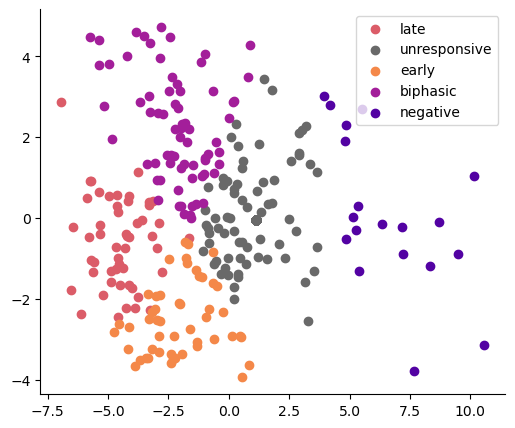

In [163]:
plt.figure(figsize=(6,5))
for k in range(-1,5):
    _uselabel = ['unresponsive','late','unresponsive','early','biphasic','negative'][k+1]
    if k!=-1:
        plt.scatter(proj[:,0][Z==k], proj[:,1][Z==k], c=colors[_uselabel], label=_uselabel)
    else:
        plt.scatter(proj[:,0][Z==k], proj[:,1][Z==k], c=colors[_uselabel])
plt.legend()

# apply gaze shift clustering

In [166]:
with open('/home/niell_lab/Data/freely_moving_ephys/batch_files/013023/dEye_PSTH_km_model1A-new.pickle', 'rb') as f:
    km = pickle.load(f)
with open('/home/niell_lab/Data/freely_moving_ephys/batch_files/013023/dEye_PSTH_pca_model1A1-new.pickle', 'rb') as f:
    pca = pickle.load(f)

    
pca_input = np.zeros([len(flhf[flhf['hasSn']].index), 350])*np.nan

for i, ind in enumerate(flhf[flhf['hasSn']].index.values):
    
    if flhf.loc[ind, 'Sn_responsive'] == True:
        pca_input[i,:] = flhf.loc[ind, 'Sn_norm_psth'][950:1300]
    
    elif flhf.loc[ind, 'Sn_responsive'] == False:
        pca_input[i,:] = np.zeros(350)
    
keep_pcas = 4
proj = pca.transform(pca_input)

gproj = proj[:,:keep_pcas]

Z = km.predict(gproj)


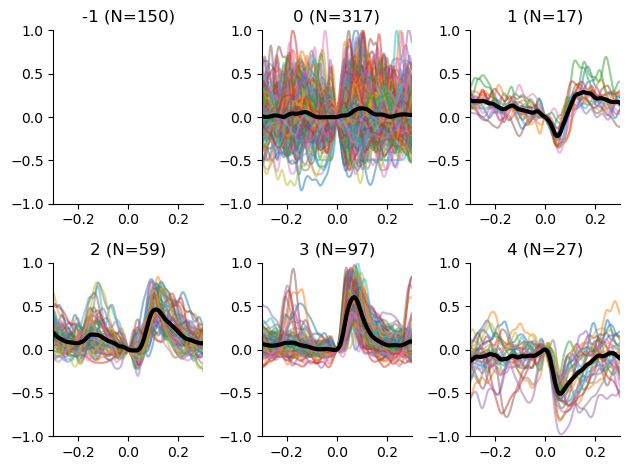

In [168]:
flhf['gazecluster_ind'] = -1
for i, ind in enumerate(flhf[flhf['hasSn']].index.values):
    flhf.at[ind, 'gazecluster_ind'] = Z[i]
     
psth_bins = np.arange(-1,1.001,1/1000)
for n, name in enumerate(range(-1,5)):
    plt.subplot(2,3,n+1)
    plotvals = flhf['Sn_norm_psth'][flhf['gazecluster_ind']==name] # pref_gazeshift_psth
    if len(plotvals.index.values)==0:
        continue
    cluster = fmEphys.flatten_series(plotvals)
    for i in range(np.size(cluster,0)):
        plt.plot(psth_bins, cluster[i,:], alpha=0.5)
    plt.plot(psth_bins, np.nanmean(cluster,0), 'k-', linewidth=3)
    plt.title('{} (N={})'.format(name, np.size(cluster, 0)))
    plt.xlim([-0.3,0.3])
    plt.ylim([-1,1])
plt.tight_layout()

In [169]:
cluster_dict = {
    3:  'early',
    2:  'late',
    1:  'biphasic',
    4:  'negative',
    -1: 'unresponsive',
    0:  'unresponsive'
}

for ind, row in flhf['gazecluster_ind'].iteritems():
    flhf.at[ind, 'gazecluster'] = cluster_dict[row]

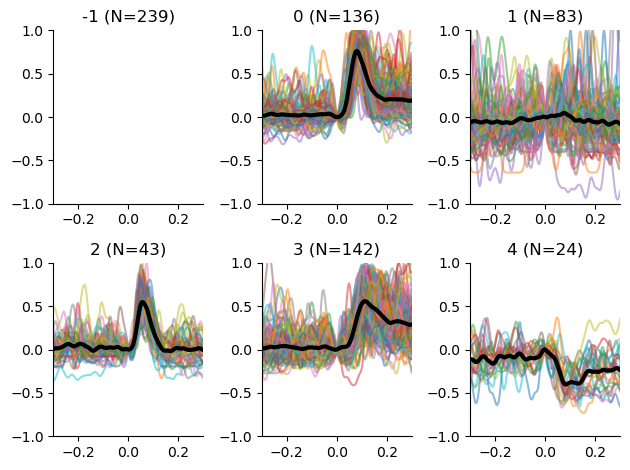

In [116]:
flhf['SnIcluster_ind'] = -1
for i, ind in enumerate(flhf[flhf['hasSnI']].index.values):
    flhf.at[ind, 'SnIcluster_ind'] = Z_sni[i]

psth_bins = np.arange(-1,1.001,1/1000)
for n, name in enumerate(range(-1,5)):
    plt.subplot(2,3,n+1)
    plotvals = flhf['SnI_norm_psth'][flhf['SnIcluster_ind']==name] # pref_gazeshift_psth
    if len(plotvals.index.values)==0:
        continue
    cluster = fmEphys.flatten_series(plotvals)
    for i in range(np.size(cluster,0)):
        plt.plot(psth_bins, cluster[i,:], alpha=0.5)
    plt.plot(psth_bins, np.nanmean(cluster,0), 'k-', linewidth=3)
    plt.title('{} (N={})'.format(name, np.size(cluster, 0)))
    plt.xlim([-0.3,0.3])
    plt.ylim([-1,1])
plt.tight_layout()

In [118]:
cluster_dict = {
    2:  'early',
    0:  'late',
    3:  'biphasic',
    4:  'negative',
    -1: 'unresponsive',
    1:  'unresponsive'
}

for ind, row in flhf['Sncluster_ind'].iteritems():
    flhf.at[ind, 'Sn_cluster'] = cluster_dict[row]
    
for ind, row in flhf['SnIcluster_ind'].iteritems():
    flhf.at[ind, 'SnI_cluster'] = cluster_dict[row]

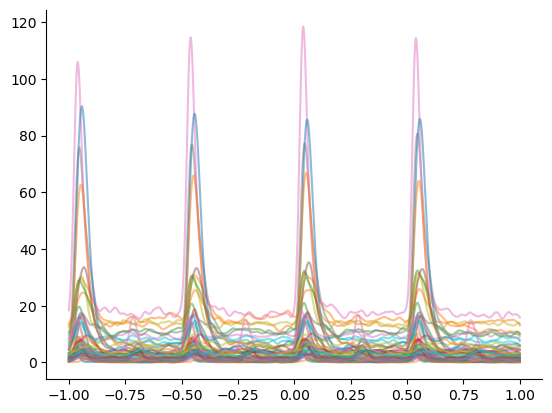

In [119]:
plotvals = flhf['Sn_recalc_stim_psth'][flhf['Sncluster_ind']==2]
cluster = fmEphys.flatten_series(plotvals)
for i in range(np.size(cluster,0)):
    plt.plot(psth_bins, cluster[i,:], alpha=0.5)

In [91]:
flhf['Sncluster_ind'].value_counts()

 3    327
-1    150
 2     70
 1     51
 0     51
 4     18
Name: Sncluster_ind, dtype: int64

In [218]:
len(flhf['session'][flhf['hasSn']].unique())

7

In [219]:
len(flhf['session'][flhf['hasSnI']].unique())

5

In [216]:
flhf['gazecluster'][flhf['hasSn']].value_counts()

517

In [215]:
flhf['gazecluster'][flhf['hasSnI']].value_counts()

428

In [124]:
flipinds = []
for ind, row in flhf.iterrows():
    if row['Sn_cluster']!=row['SnI_cluster']:
        flipinds.append(ind)

In [127]:
len(flipinds)/len(flhf.index.values)

0.5037481259370314

# figure

In [117]:
flhf['session'][flhf['hasSn']][flhf['Sn_cluster']!='unresponsive'][flhf['Sn_responsive']==True].unique()

array(['041822_J594NC_control_Rig2', '042022_J604RT_control_Rig2',
       '042122_J604RT_control_Rig2', '042222_J594RT_control_Rig2',
       '060822_J611RN_control_Rig2', '060922_J611RN_control_Rig2'],
      dtype=object)

In [116]:
flhf['session'][flhf['hasSnI']][flhf['Sn_cluster']!='unresponsive'][flhf['SnI_responsive']==True].unique()

array(['041822_J594NC_control_Rig2', '042022_J604RT_control_Rig2',
       '042222_J594RT_control_Rig2'], dtype=object)

In [229]:
flhf['gazecluster'][flhf['_use']].value_counts()

early       71
late        33
biphasic     9
negative     7
Name: gazecluster, dtype: int64

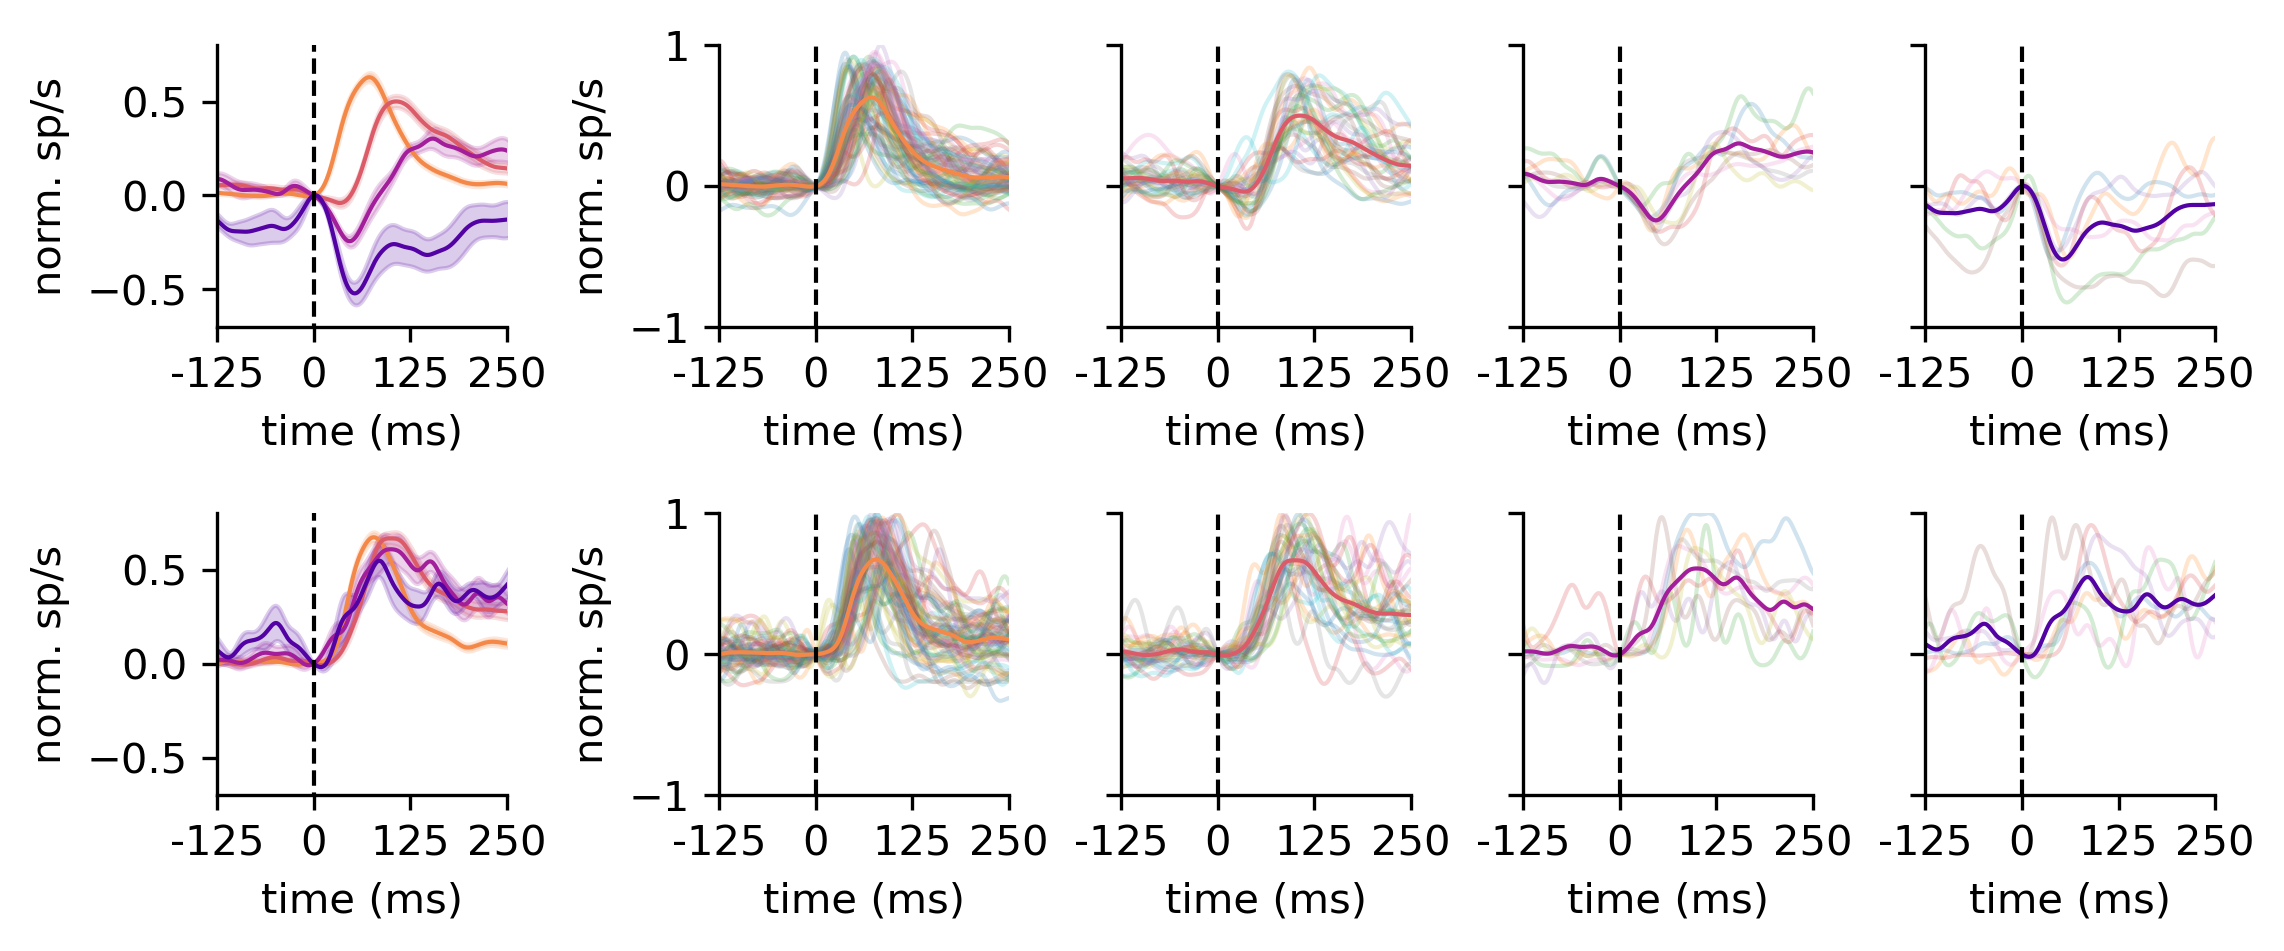

In [226]:

fig = plt.figure(constrained_layout=True, figsize=(7.5,5), dpi=300)
fig_spec = gridspec.GridSpec(nrows=4, ncols=5, figure=fig, wspace=0.02, hspace=0.12)

# ax_rc = fig.add_subplot(fig_spec[0,0])
# ax_rc_early = fig.add_subplot(fig_spec[0,1])
# ax_rc_late = fig.add_subplot(fig_spec[0,2])
# ax_rc_biphasic = fig.add_subplot(fig_spec[0,3])
# ax_rc_negative = fig.add_subplot(fig_spec[0,4])

ax_sn = fig.add_subplot(fig_spec[1,0])
ax_sn_early = fig.add_subplot(fig_spec[1,1])
ax_sn_late = fig.add_subplot(fig_spec[1,2])
ax_sn_biphasic = fig.add_subplot(fig_spec[1,3])
ax_sn_negative = fig.add_subplot(fig_spec[1,4])

ax_snISI = fig.add_subplot(fig_spec[2,0])
ax_snISI_early = fig.add_subplot(fig_spec[2,1])
ax_snISI_late = fig.add_subplot(fig_spec[2,2])
ax_snISI_biphasic = fig.add_subplot(fig_spec[2,3])
ax_snISI_negative = fig.add_subplot(fig_spec[2,4])

# ax_snRND = fig.add_subplot(fig_spec[3,0])
# ax_snRND_early = fig.add_subplot(fig_spec[3,1])
# ax_snRND_late = fig.add_subplot(fig_spec[3,2])
# ax_snRND_biphasic = fig.add_subplot(fig_spec[3,3])
# ax_snRND_negative = fig.add_subplot(fig_spec[3,4])


# panels_full = [[ax_rc, ax_rc_early, ax_rc_late, ax_rc_biphasic, ax_rc_negative],
panels_full = [[ax_sn, ax_sn_early, ax_sn_late, ax_sn_biphasic, ax_sn_negative],
               [ax_snISI, ax_snISI_early, ax_snISI_late, ax_snISI_biphasic, ax_snISI_negative]]
               # [ax_rsnRND, ax_rsnRND_early, ax_rsnRND_late, ax_rsnRND_biphasic, ax_rsnRND_negative]]

for panel_set_num, psth_name in enumerate(panels_full):
    
    panels = panels_full[panel_set_num]

    names = ['early','late','biphasic','negative']

    # if panel_set_num==0:
    #     use_psth = 'Rc_norm_psth'
    #     has_sort = 'hasRc'
    #     use_clust = 'gazecluster'
    #     attl_sort = None
    if panel_set_num ==0:
        use_psth = 'Sn_norm_psth'
        # attl_sort = 'Sn_responsive'
        use_clust = 'gazecluster'
        # has_sort = 'hasSn'
    elif panel_set_num==1:
        use_psth = 'SnI_norm_psth'
        # attl_sort = 'SnI_responsive'
        # use_clust = 'gazecluster'
        # has_sort = 'hasSnI'   
    has_sort = '_use'
    use_clust = 'gazecluster'
    attl_sort = None
    
    
    panel = panels[0]
    for count, name in enumerate(names):
        
        use_data = flhf[flhf[use_clust]==name][flhf[has_sort]].copy()
        if attl_sort is not None:
            use_data = use_data[use_data[attl_sort]==True]
        if panel_set_num==1:
            for ind, row in use_data.iterrows():
                if (np.mean(row[use_psth][1000:1100]) < 0.1):
                    use_data.drop(index=ind, inplace=True)
        
        cluster_psths = fmEphys.flatten_series(use_data[use_psth])
        cluster_psths = drop_nan_along(cluster_psths)
        clustmean = np.nanmean(cluster_psths, 0)
        clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
        panel.plot(psth_bins, clustmean, '-', linewidth=1, color=colors[name])
        panel.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=colors[name], alpha=0.2)
    panel.set_xlim([-0.125,0.25])
    panel.set_ylim([-.7,.8])
    panel.set_ylabel('norm. sp/s')
    panel.set_xlabel('time (ms)')
    panel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    panel.set_xticks(np.linspace(-0.125,0.25,4), labels=np.linspace(-125,250,4).astype(int))
    panel.set_yticks(np.linspace(-0.5,0.5,3))

    for count, name in enumerate(names):
        panel = panels[count+1]
        
        if count==0:
            panel.set_ylabel('norm. sp/s')
            panel.set_yticks([-1,0,1])
        else:
            panel.set_yticks([-1,0,1], labels=[])
   
        
        use_data = flhf[flhf[use_clust]==name][flhf[has_sort]].copy()
        if attl_sort is not None:
            use_data = use_data[use_data[attl_sort]==True]
        if panel_set_num==1:
            for ind, row in use_data.iterrows():
                if (np.mean(row[use_psth][1000:1100]) < 0.1):
                    use_data.drop(index=ind, inplace=True)
        
        cluster_psths = fmEphys.flatten_series(use_data[use_psth])
        for i in range(np.size(cluster_psths,0)):
            panel.plot(psth_bins, cluster_psths[i], '-', linewidth=1, alpha=0.2)
        cluster_psths = drop_nan_along(cluster_psths)
        clustmean = np.nanmean(cluster_psths, 0)
        clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
        panel.plot(psth_bins, np.mean(cluster_psths,0), '-', linewidth=1, color=colors[name])
        # panel.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=colors[name], alpha=0.2)
        panel.set_xlim([-0.125,0.25])
        panel.set_ylim([-1, 1.0])
        panel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
        panel.set_xticks(np.linspace(-0.125,0.25,4), labels=np.linspace(-125,250,4).astype(int))
        # panel.set_ylabel('norm. sp/s')
        panel.set_xlabel('time (ms)')
        # panel.set_title(np.size(cluster_psths,0))
        
    use_data = flhf[flhf[use_clust]=='unresponsive'][flhf[has_sort]].copy()
    if attl_sort is not None:
        use_data = use_data[use_data[attl_sort]==True]
        # print(len(use_data.index.values))
        
    # for count, name in 

# dark_panels = [ax_early_d, ax_late_d, ax_biphasic_d, ax_negative_d]

fig.savefig('/home/niell_lab/Desktop/Fig7AB_final.pdf')

In [220]:
flhf['_use'] = False
use_data = flhf[flhf['gazecluster']!='unresponsive'][flhf['hasSnI']][flhf['hasSn']].copy()
use_data = use_data[use_data['SnI_responsive']==True][use_data['Sn_responsive']==True]
for ind, row in use_data.iterrows():
    if (np.mean(row['SnI_norm_psth'][1000:1100]) >= 0.1):
        flhf.at[ind, '_use'] = True

array([-125,    0,  125,  250])

(array([1., 1., 1., 3., 1., 3., 1., 0., 0., 2.]),
 array([0.27242777, 0.34225162, 0.41207548, 0.48189933, 0.55172318,
        0.62154704, 0.69137089, 0.76119475, 0.8310186 , 0.90084245,
        0.97066631]),
 <BarContainer object of 10 artists>)

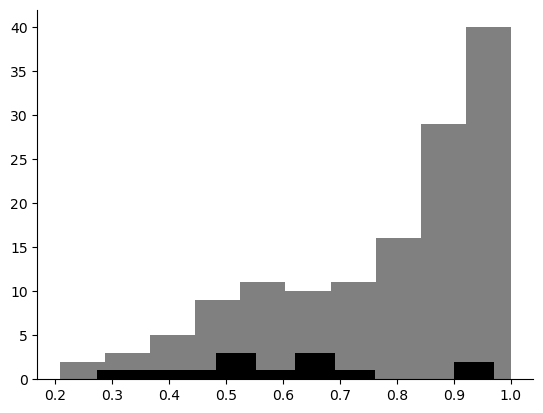

In [111]:
use_data = flhf[flhf['Sn_cluster']!='unresponsive'][flhf['SnI_responsive']][flhf['hasSnI']].copy()
plt.hist(use_data['norm_mod_for_SnI'], color='grey')
use_data = flhf[flhf['Sn_cluster']=='negative'][flhf['SnI_responsive']][flhf['hasSnI']].copy()
plt.hist(use_data['norm_mod_for_SnI'], color='k')

14


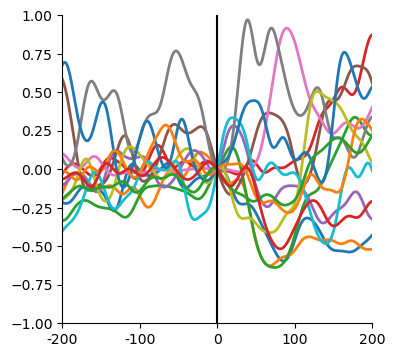

In [138]:
plt.figure(figsize=(4,4))
use_data = flhf[flhf['Sn_cluster']=='negative'][flhf['SnI_responsive']][flhf['hasSnI']].copy()
# for ind, row in use_data.iterrows():
#     if (np.max(row['SnI_norm_psth'][1000:1075]) < 0.01):
#         use_data.drop(index=ind, inplace=True)
cluster_psths = fmEphys.flatten_series(use_data['SnI_norm_psth'])
for i in range(np.size(cluster_psths,0)):
    plt.plot(psth_bins, cluster_psths[i,:], '-', linewidth=2)
plt.xlim([-.2,.2])
plt.ylim([-1,1])
plt.xticks([-.2,-.1,0,.1,.2], labels=[-200,-100,0,100,200])
plt.vlines(0, -1, 1, 'k')
print(np.size(cluster_psths,0))

In [134]:
np.shape(cluster_psths)

(14, 2001)

In [99]:
row

2

In [96]:
np.max(row[use_psth][1000:1500])

TypeError: 'int' object is not subscriptable

# stats

In [ ]:
use_psth = 'Sn_norm_psth'
attl_sort = 'Sn_responsive'
use_clust = 'Sn_cluster'
has_sort = 'hasSn'

use_psth = 'SnI_norm_psth'
attl_sort = 'SnI_responsive'
use_clust = 'Sn_cluster'
has_sort = 'hasSnI' 

In [74]:
35+46+41+14+182

318

In [67]:
len(flhf[flhf['hasSnI']][flhf['hasSn']][flhf['Sn_responsive']][flhf['SnI_responsive']].index.values)

177

In [58]:
np.sum(flhf['SnI_responsive'][flhf['hasSnI']][flhf['hasSn']])

317

In [ ]:
np.sum(flhf['SnI_responsive'])

In [87]:
flhf['SnI_responsive'][flhf['hasSnI']][flhf['hasSn']].sum()

317

In [90]:
flhf['Sn_cluster'][flhf['SnI_responsive']][flhf['hasSnI']][flhf['hasSn']].value_counts()

unresponsive    182
late             46
biphasic         41
early            34
negative         14
Name: Sn_cluster, dtype: int64

# --- old stuff below here ---

In [93]:
177-(34+46+41+14)

42

In [78]:
50+53+67+19+70

259

In [705]:
for ind, row in flhf[flhf['hasRc']].iterrows():
    sec = row['Rc_eyeT'][-1].astype(float) - row['Rc_eyeT'][0].astype(float)
    sp = len(row['Rc_spikeT'])
    flhf.at[ind, 'Rc_fr'] = sp/sec

    flhf.at[ind, 'raw_mod_for_Rc'] = calc_PSTH_modind(row['Rc_stim_PSTH'], baseval='tight')

    flhf.at[ind, 'norm_mod_for_Rc'] = calc_PSTH_modind(row['Rc_norm_psth'], baseval='tight')
    
flhf['Rc_responsive'] = False
for ind, row in flhf[flhf['hasRc']].iterrows():
    if (row['raw_mod_for_Rc']>1) and (row['norm_mod_for_Rc']>0.1):
        flhf.at[ind, 'Rc_responsive'] = True
print(flhf['Rc_responsive'].sum(), '/', len(flhf.index))

371 / 665


In [706]:
for ind, row in flhf[flhf['hasSn']].iterrows():
    sec = row['Sn_eyeT'][-1].astype(float) - row['Sn_eyeT'][0].astype(float)
    sp = len(row['Sn_spikeT'])
    flhf.at[ind, 'Sn_fr'] = sp/sec

    flhf.at[ind, 'raw_mod_for_Sn'] = calc_PSTH_modind(row['Sn_recalc_stim_psth'], baseval='tight')

    flhf.at[ind, 'norm_mod_for_Sn'] = calc_PSTH_modind(row['Sn_norm_psth'], baseval='tight')
    
flhf['Sn_responsive'] = False
for ind, row in flhf[flhf['hasSn']].iterrows():
    if (row['raw_mod_for_Sn']>1) and (row['norm_mod_for_Sn']>0.1):
        flhf.at[ind, 'Sn_responsive'] = True
print(flhf['Sn_responsive'].sum(), '/', len(flhf.index))

298 / 665


In [707]:
for ind, row in flhf[flhf['hasSnI']].iterrows():
    sec = row['SnI_eyeT'][-1].astype(float) - row['SnI_eyeT'][0].astype(float)
    sp = len(row['SnI_spikeT'])
    flhf.at[ind, 'Sn_fr'] = sp/sec

    flhf.at[ind, 'raw_mod_for_SnI'] = calc_PSTH_modind(row['SnI_recalc_stim_psth'], baseval='tight')

    flhf.at[ind, 'norm_mod_for_SnI'] = calc_PSTH_modind(row['SnI_norm_psth'], baseval='tight')
    
flhf['SnI_responsive'] = False
for ind, row in flhf[flhf['hasSn']].iterrows():
    if (row['raw_mod_for_SnI']>1) and (row['norm_mod_for_SnI']>0.1):
        flhf.at[ind, 'SnI_responsive'] = True
print(flhf['SnI_responsive'].sum(), '/', len(flhf.index))

310 / 665


In [88]:
tmp_arr = np.zeros(350)*np.nan
tmp_series = pd.Series([])
for i in range(len(flhf.index.values)):
    tmp_series.at[i] = tmp_arr.astype(object)

flhf['pca_input_arr'] = tmp_series.copy()

tmp_arr = np.zeros(350)*np.nan
tmp_series = pd.Series([])
for i in range(len(hffm.index.values)):
    tmp_series.at[i] = tmp_arr.astype(object)

hffm['pca_input_arr'] = tmp_series.copy()

In [117]:
_flhf = flhf[['Rc_responsive','Rc_norm_psth','pca_input_arr']][flhf['hasRc']==True].copy()
_hffm = hffm[['Rc_responsive','norm_Rc_psth','pca_input_arr']].copy()

In [151]:
pca_input = np.zeros([len(_flhf.index)+len(_hffm.index), 350])*np.nan

# flhf
for i, ind in enumerate(_flhf.index.values):
    
    if _flhf.loc[ind, 'Rc_responsive'] == True:
        pca_input[i,:] = _flhf.loc[ind, 'Rc_norm_psth'][950:1300]
        flhf.at[ind, 'pca_input_arr'] = _flhf.loc[ind, 'Rc_norm_psth'][950:1300]
    
    elif _flhf.loc[ind, 'Rc_responsive'] == False:
        pca_input[i,:] = np.zeros(350)
        flhf.at[ind, 'pca_input_arr'] = np.zeros(350)
        
# hffm
for i, ind in enumerate(_hffm.index.values):
    i = i + len(_flhf.index)
    
    if _hffm.loc[ind, 'Rc_responsive'] == True:
        pca_input[i,:] = _hffm.loc[ind, 'norm_Rc_psth'][950:1300]
    
    elif _hffm.loc[ind, 'Rc_responsive'] == False:
        pca_input[i,:] = np.zeros(350)

# cluster

ValueError: 'c' argument has 509 elements, which is inconsistent with 'x' and 'y' with size 510.

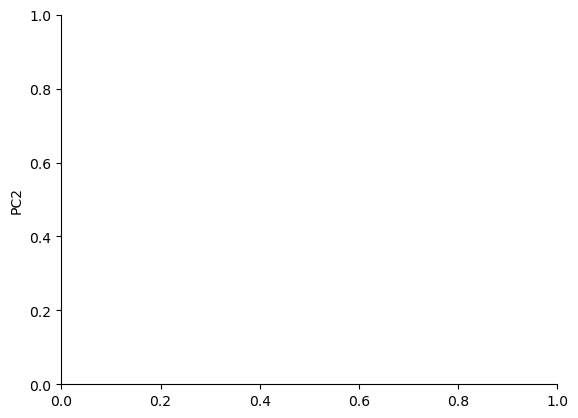

In [389]:
_path = '/home/niell_lab/Data/freely_moving_ephys/batch_files/013023/PCA_projection_013123-17h-42m-29s.npy'
proj = np.load(_path)

plt.ylabel('PC1')
plt.ylabel('PC2')
plt.scatter(proj[:510,0], proj[:510,1], c=Z, marker='o')
plt.scatter(proj[510:,0], proj[510:,1], c=Z, marker='x')

In [157]:
pca_input = fmEphys.flatten_series(flhf['pca_input_arr'][flhf['hasRc']])

proj = pca.transform(pca_input)

gproj = proj[:,:6]

Z = km.predict(gproj)

# prepare clustering

using best 3 PCs


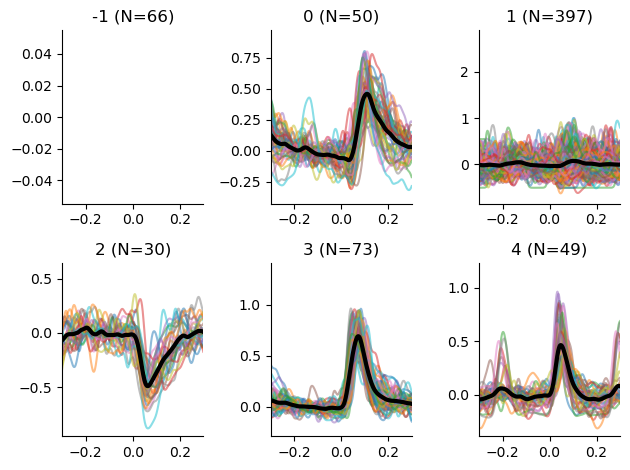

In [712]:
psth_bins[1300]

0.30000000000000115

In [701]:
gazedict = {
    1:  'early',
    2:  'late',
    2:  'biphasic',
    3:  'negative',
    -1: 'unresponsive',
    0:  'unresponsive'
}

for ind, row in flhf['Sncluster_ind'].iteritems():
    flhf.at[ind, 'Sncluster'] = gazedict[row]

In [548]:
pca_input = np.zeros([len(flhf[flhf['hasSnI']].index), 350])*np.nan

for i, ind in enumerate(flhf[flhf['hasSnI']].index.values):
    
    if flhf.loc[ind, 'SnI_responsive'] == True:
        pca_input[i,:] = flhf.loc[ind, 'SnI_norm_psth'][950:1300]
    
    elif flhf.loc[ind, 'SnI_responsive'] == False:
        pca_input[i,:] = np.zeros(350)

# n_pcas = 10
req_explvar=0.95

# pca = sklearn.decomposition.PCA(n_components=n_pcas)
# pca.fit(pca_input)

# explvar = pca.explained_variance_ratio_

proj = pca.transform(pca_input)

keep_pcas = int(np.argwhere(np.cumsum(explvar)>req_explvar)[0])
print('using best {} PCs'.format(keep_pcas))

gproj = proj[:,:6]

# km = sklearn.cluster.KMeans(n_clusters=5)
km.predict(gproj)
Z = km.labels_

flhf['SnIcluster_ind'] = -1
for i, ind in enumerate(flhf[flhf['hasSnI']].index.values):
    flhf.at[ind, 'SnIcluster_ind'] = Z[i]

psth_bins = np.arange(-1,1.001,1/1000)
for n, name in enumerate(range(-1,5)):
    plt.subplot(2,3,n+1)
    plotvals = flhf['Sn_norm_psth'][flhf['Sncluster_ind']==name] # pref_gazeshift_psth
    if len(plotvals.index.values)==0:
        continue
    cluster = fmEphys.flatten_series(plotvals)
    for i in range(np.size(cluster,0)):
        plt.plot(psth_bins, cluster[i,:], alpha=0.5)
    plt.plot(psth_bins, np.nanmean(cluster,0), 'k-', linewidth=3)
    plt.title('{} (N={})'.format(name, len(plotvals)))
    plt.xlim([-0.3,0.3])
    # plt.ylim([-1,1.3])
plt.tight_layout()

In [548]:
gazedict = {
    3:  'early',
    1:  'late',
    2:  'biphasic',
    4:  'negative',
    -1: 'unresponsive',
    0:  'unresponsive'
}

for ind, row in flhf['Sncluster_ind'].iteritems():
    flhf.at[ind, 'Sncluster'] = gazedict[row]

using best 6 PCs


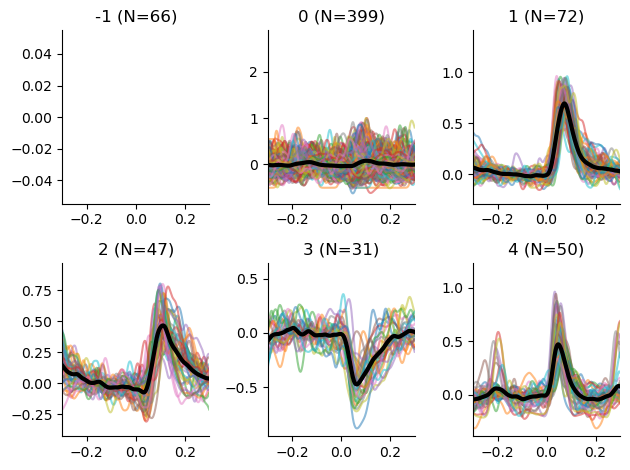

In [700]:
psth_bins = np.arange(-1,1.001,1/1000)
for n, name in enumerate(range(-1,5)):
    plt.subplot(2,3,n+1)
    plotvals = flhf['Sn_norm_psth'][flhf['Sncluster_ind']==name] # pref_gazeshift_psth
    if len(plotvals.index.values)==0:
        continue
    cluster = fmEphys.flatten_series(plotvals)
    for i in range(np.size(cluster,0)):
        plt.plot(psth_bins, cluster[i,:], alpha=0.5)
    plt.plot(psth_bins, np.nanmean(cluster,0), 'k-', linewidth=3)
    plt.title('{} (N={})'.format(name, len(plotvals)))
    plt.xlim([-0.3,0.3])
    # plt.ylim([-1,1.3])
plt.tight_layout()

In [702]:
gazedict = {
    3:  'early',
    1:  'late',
    2:  'biphasic',
    4:  'negative',
    -1: 'unresponsive',
    0:  'unresponsive'
}

for ind, row in flhf['SnIcluster_ind'].iteritems():
    flhf.at[ind, 'SnIcluster'] = gazedict[row]

In [695]:
flhf[''][flhf['Sncluster']=='negative']

80         biphasic
81             late
82         biphasic
83     unresponsive
84         negative
           ...     
662    unresponsive
663           early
664    unresponsive
665           early
666        biphasic
Name: Sncluster, Length: 665, dtype: object

# figure

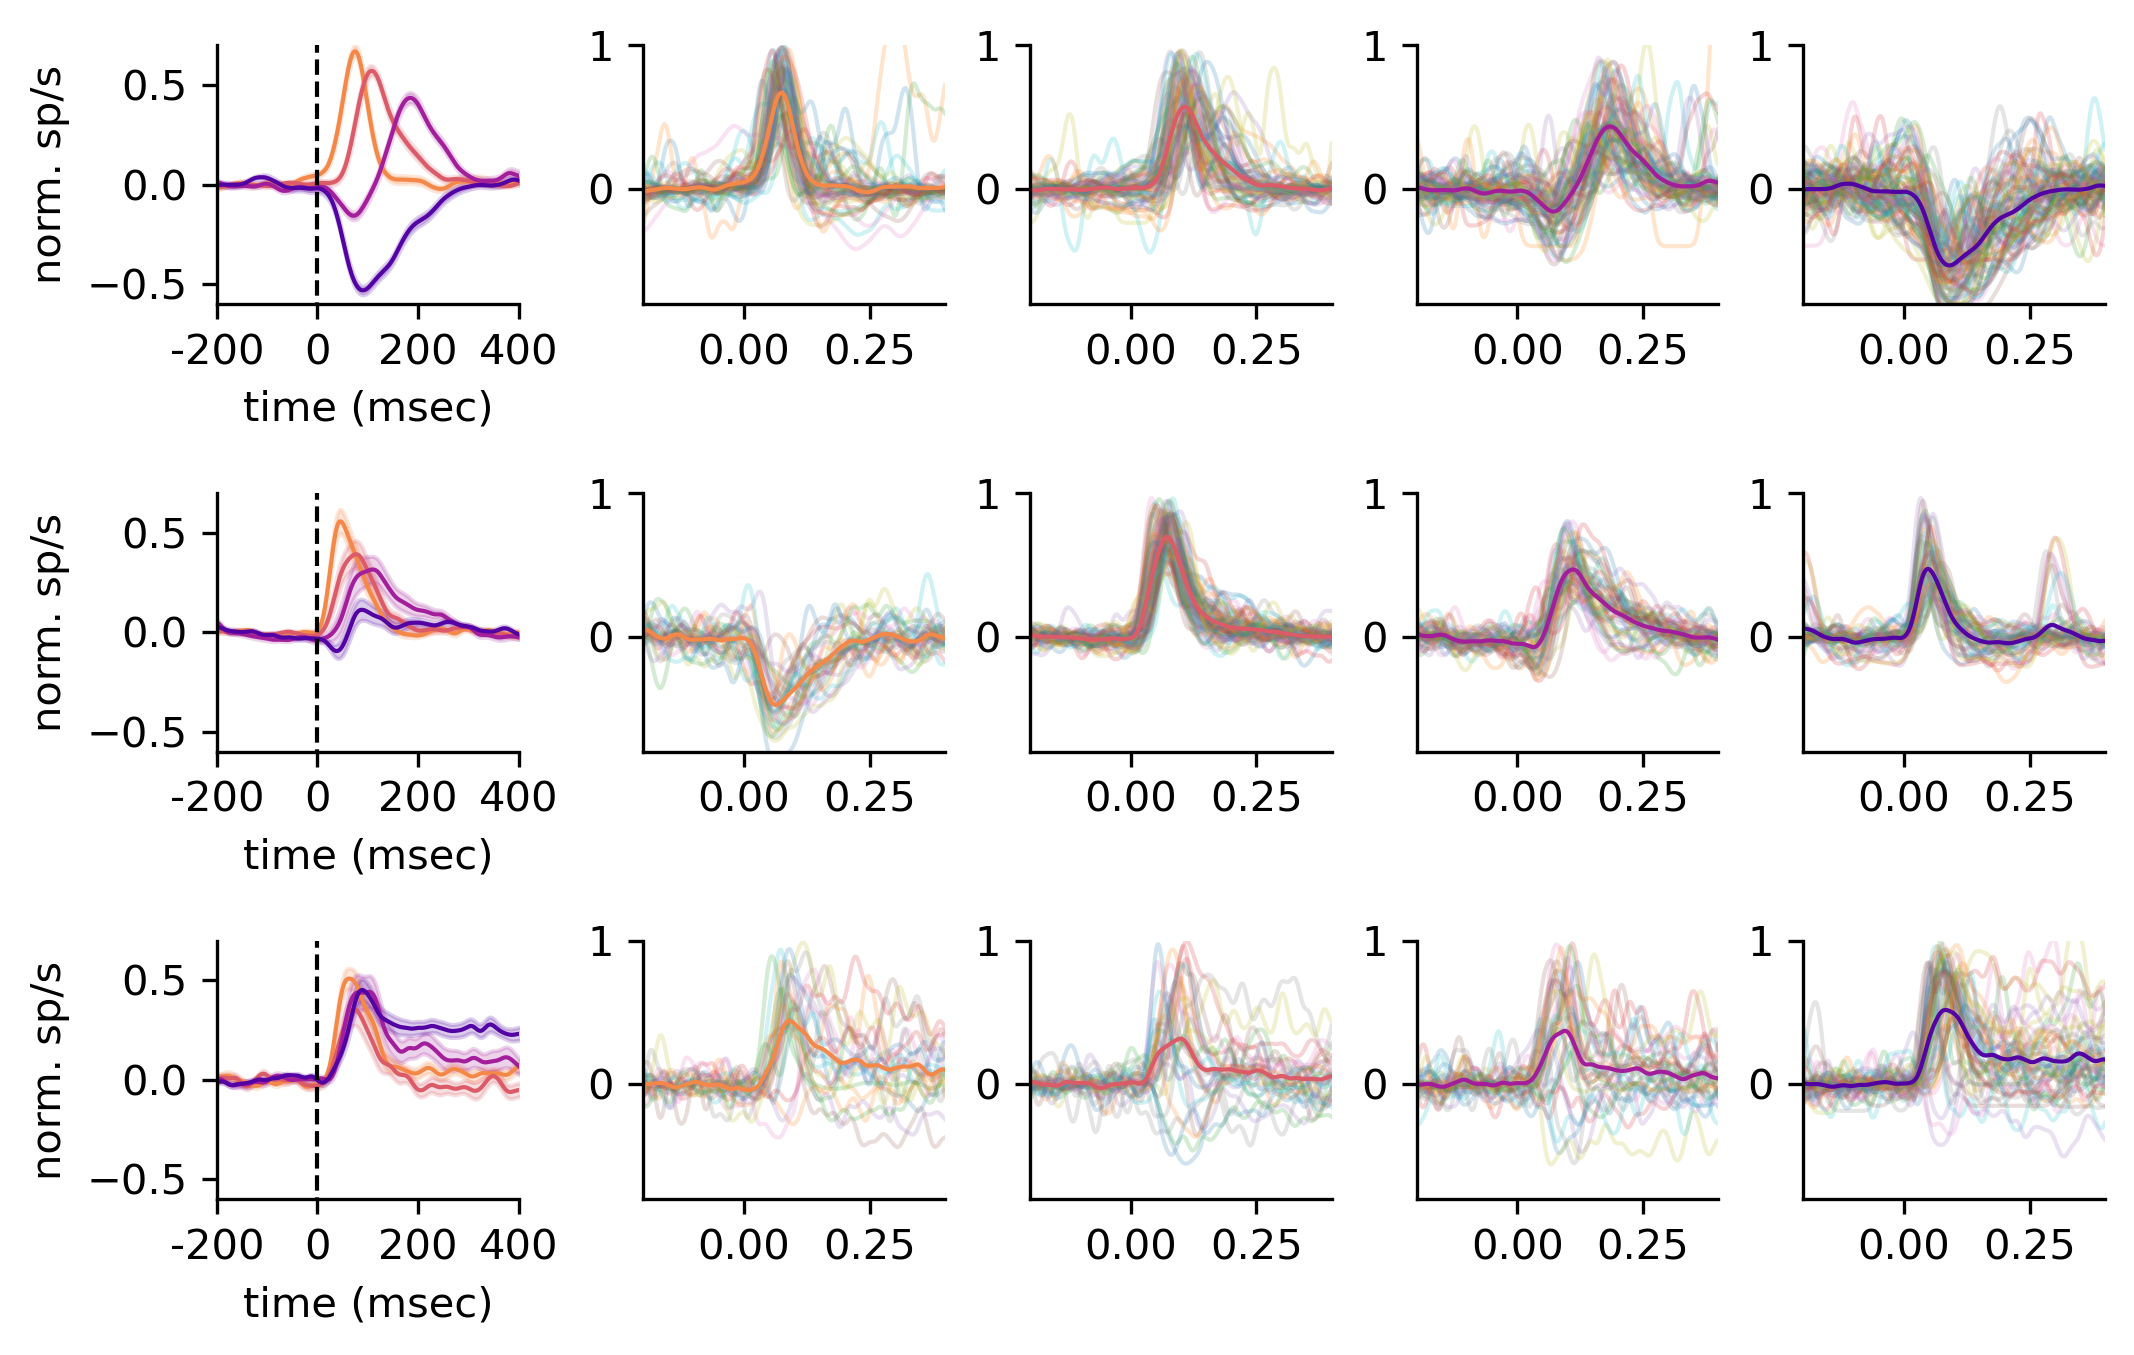

In [699]:
# Apply the models to the dataframe for flashed head-fixed recordings

fig = plt.figure(constrained_layout=True, figsize=(7,5.3), dpi=300)
fig_spec = gridspec.GridSpec(nrows=4, ncols=5, figure=fig, wspace=0.07, hspace=0.12)

ax_rc = fig.add_subplot(fig_spec[0,0])
ax_rc_early = fig.add_subplot(fig_spec[0,1])
ax_rc_late = fig.add_subplot(fig_spec[0,2])
ax_rc_biphasic = fig.add_subplot(fig_spec[0,3])
ax_rc_negative = fig.add_subplot(fig_spec[0,4])

ax_sn = fig.add_subplot(fig_spec[1,0])
ax_sn_early = fig.add_subplot(fig_spec[1,1])
ax_sn_late = fig.add_subplot(fig_spec[1,2])
ax_sn_biphasic = fig.add_subplot(fig_spec[1,3])
ax_sn_negative = fig.add_subplot(fig_spec[1,4])

ax_snISI = fig.add_subplot(fig_spec[2,0])
ax_snISI_early = fig.add_subplot(fig_spec[2,1])
ax_snISI_late = fig.add_subplot(fig_spec[2,2])
ax_snISI_biphasic = fig.add_subplot(fig_spec[2,3])
ax_snISI_negative = fig.add_subplot(fig_spec[2,4])

# ax_snRND = fig.add_subplot(fig_spec[3,0])
# ax_snRND_early = fig.add_subplot(fig_spec[3,1])
# ax_snRND_late = fig.add_subplot(fig_spec[3,2])
# ax_snRND_biphasic = fig.add_subplot(fig_spec[3,3])
# ax_snRND_negative = fig.add_subplot(fig_spec[3,4])


panels_full = [[ax_rc, ax_rc_early, ax_rc_late, ax_rc_biphasic, ax_rc_negative],
               [ax_sn, ax_sn_early, ax_sn_late, ax_sn_biphasic, ax_sn_negative],
               [ax_snISI, ax_snISI_early, ax_snISI_late, ax_snISI_biphasic, ax_snISI_negative]]
               # [ax_rsnRND, ax_rsnRND_early, ax_rsnRND_late, ax_rsnRND_biphasic, ax_rsnRND_negative]]

for panel_set_num, psth_name in enumerate(panels_full):
    
    panels = panels_full[panel_set_num]

    names = ['early','late','biphasic','negative']
    
    
    if panel_set_num==0:
        use_psth = 'Rc_norm_psth'
        has_sort = 'hasRc'
        use_clust = 'gazecluster'
        attl_sort = None
    elif panel_set_num ==1:
        use_psth = 'Sn_norm_psth'
        attl_sort = 'Sn_responsive'
        use_clust = 'Sncluster'
        has_sort = 'hasSn'
    elif panel_set_num==2:
        use_psth = 'SnI_norm_psth'
        attl_sort = 'SnI_responsive'
        use_clust = 'SnIcluster'
        has_sort = 'hasSnI'     
    
    panel = panels[0]
    for count, name in enumerate(names):
        
        use_data = flhf[flhf['gazecluster']==name][flhf[has_sort]].copy()
        if attl_sort is not None:
            use_data = use_data[use_data[attl_sort]==True]
        
        cluster_psths = fmEphys.flatten_series(use_data[use_psth])
        cluster_psths = drop_nan_along(cluster_psths)
        clustmean = np.nanmean(cluster_psths, 0)
        clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
        panel.plot(psth_bins, clustmean, '-', linewidth=1, color=colors[name])
        panel.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=colors[name], alpha=0.2)
    panel.set_xlim([-0.2,0.4])
    panel.set_ylim([-.6,.7])
    panel.set_ylabel('norm. sp/s')
    panel.set_xlabel('time (msec)')
    panel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    panel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
    panel.set_yticks(np.linspace(-0.5,0.5,3))

    for count, name in enumerate(names):
        panel = panels[count+1]
        
        use_data = flhf[flhf[use_clust]==name][flhf[has_sort]].copy()
        if attl_sort is not None:
            use_data = use_data[use_data[attl_sort]==True]
        
        cluster_psths = fmEphys.flatten_series(use_data[use_psth])
        for i in range(np.size(cluster_psths,0)):
            panel.plot(psth_bins, cluster_psths[i], '-', linewidth=1, alpha=0.2)
        cluster_psths = drop_nan_along(cluster_psths)
        clustmean = np.nanmean(cluster_psths, 0)
        clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
        panel.plot(psth_bins, np.mean(cluster_psths,0), '-', linewidth=1, color=colors[name])
        # panel.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=colors[name], alpha=0.2)
        panel.set_xlim([-0.2,0.4])
        panel.set_ylim([-.8, 1.0])
        # panel.set_ylabel('norm. sp/s')
        # panel.set_xlabel('time (msec)')
        
    # for count, name in 


# dark_panels = [ax_early_d, ax_late_d, ax_biphasic_d, ax_negative_d]

# fig.savefig('/home/niell_lab/Desktop/addtl_flashed_headfixed.pdf')

In [259]:
len(flhf[flhf['hasSnI']==True][flhf['SnI_responsive']==True].index)

241

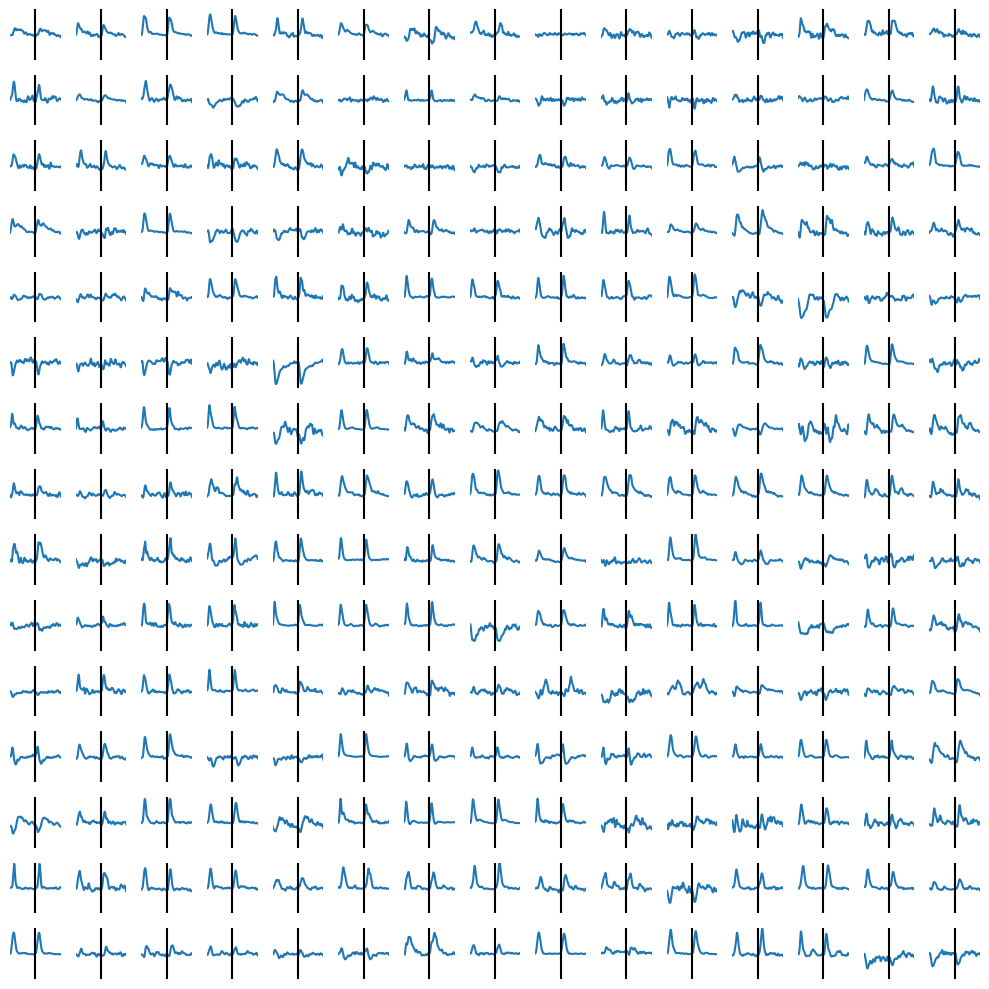

In [274]:
fig, axs = plt.subplots(15,15,figsize=(10,10))
axs = axs.flatten()
for i, ind in enumerate(flhf[flhf['hasSnI']==True][flhf['SnI_responsive']==True].index.values):
    
    if i >= (15*15):
        break
    
    axs[i].plot(flhf.loc[ind,'SnI_norm_psth']) # SnI_stim_PSTH_onSub_bckgndRF
    axs[i].set_xlim([1000,2000])
    axs[i].vlines(1500, -1, 1, 'k')
    axs[i].set_ylim([-1,1])
    
    axs[i].axis('off')
    
fig.tight_layout()

In [299]:
flhf['SnI_worldT'][flhf['SnI_responsive']==True].iloc[0][-1]

1217.3029059999972

In [301]:
flhf['SnI_stimT_all_shared'][flhf['SnI_responsive']==True].iloc[0][-1]

1217.2628233333328

(0.0, 10.0)

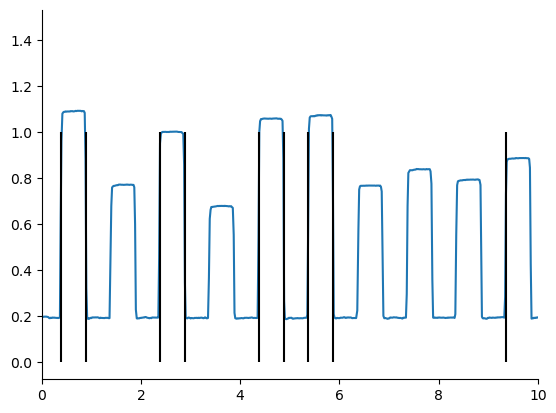

In [294]:
plt.plot(flhf['SnI_worldT'][flhf['SnI_responsive']==True].iloc[0], flhf['SnI_contrast'][flhf['SnI_responsive']==True].iloc[0])
plt.vlines(flhf['SnI_stimT_all_shared'][flhf['SnI_responsive']==True].iloc[0], 0, 1, 'k')
plt.xlim([0,10])

# recalc PSTHs for SN with ISI

In [602]:
# for ind, row in flhf['hasSnR'].iterrows():
tmp_arr = np.zeros(2001)*np.nan
tmp_series = pd.Series([])
for i in range(len(hffm.index.values)):
    tmp_series.at[i] = tmp_arr.astype(object)
flhf['SnI_recalc_stim_psth'] = tmp_series.copy()

for s in flhf['session'][flhf['hasSnI']].unique():
    row = flhf[flhf['session']==s].iloc[0].copy()
    
    stim_time = row['SnI_worldT']
    stimcontrast = row['SnI_contrast']
    
    stim_on = np.diff((stimcontrast>0.25))==1
    
    _arr_test = np.diff(np.diff(stimcontrast)>0.2)
    _new_arr = []
    for i in range(_arr_test.size):
        if (_arr_test[i-1]==True) and (_arr_test[i]==True):
            _new_arr.append(True)
        else:
            _new_arr.append(False)

    stim_onset_times = row['SnI_worldT'][:-2][_new_arr]
    
    for ind, row in tqdm(flhf[flhf['session']==s][flhf['hasSnI']].iterrows()):
        sps = row['SnI_spikeT']
        
        flhf.at[ind, 'SnI_recalc_stim_psth'] = calc_kde_PSTH(sps, stim_onset_times).astype(object)
    

78it [00:13,  5.65it/s]
187it [00:07, 23.58it/s]
16it [00:01,  9.81it/s]
61it [00:02, 20.41it/s]


# and recalc for non-ISI Sn

In [ ]:
# recording 0 is labeled as having a Sn recording but not a SnI recording. This is wrong.
# It is an ISI recording but not labled that way

In [718]:
flhf['session'][flhf['hasSn']].unique()[0]

'041422_J593LT_control_Rig2'

In [685]:
# for ind, row in flhf['hasSnR'].iterrows():
tmp_arr = np.zeros(2001)*np.nan
tmp_series = pd.Series([])
for i in range(len(hffm.index.values)):
    tmp_series.at[i] = tmp_arr.astype(object)
flhf['Sn_recalc_stim_psth'] = tmp_series.copy()

for s in flhf['session'][flhf['hasSn']].unique()[1:]:
    row = flhf[flhf['session']==s].iloc[0].copy()
    
    stim_time = row['Sn_worldT']
    stimcontrast = row['Sn_contrast']
    
    stim_on = np.diff((stimcontrast>0.25))==1
    
    _arr_test = np.abs(np.diff(stimcontrast))>0.05
    _new_arr = []
    for i in range(_arr_test.size):
        if (_arr_test[i-1]==True) and (_arr_test[i]==True):
            _new_arr.append(True)
        else:
            _new_arr.append(False)

    stim_onset_times = row['Sn_worldT'][:-1][_new_arr]
    
    for ind, row in tqdm(flhf[flhf['session']==s][flhf['hasSn']].iterrows()):
        sps = row['Sn_spikeT']
        
        flhf.at[ind, 'Sn_recalc_stim_psth'] = calc_kde_PSTH(sps, stim_onset_times).astype(object)
    

78it [00:35,  2.18it/s]
187it [00:51,  3.63it/s]
16it [00:03,  4.68it/s]
17it [00:06,  2.61it/s]
61it [00:21,  2.90it/s]
74it [00:17,  4.28it/s]
82it [00:21,  3.78it/s]


In [648]:
flhf['hasSn'][flhf['session']==s]

585    True
586    True
587    True
588    True
589    True
       ... 
662    True
663    True
664    True
665    True
666    True
Name: hasSn, Length: 82, dtype: bool

In [682]:
s = flhf['session'][flhf['hasSn']].unique()[1]
row = flhf[flhf['session']==s].iloc[0].copy()

stim_time = row['Sn_worldT']
stimcontrast = row['Sn_contrast']

_arr_test = np.abs(np.diff(stimcontrast))>0.05
_new_arr = []
for i in range(_arr_test.size):
    if (_arr_test[i-1]==True) and (_arr_test[i]==True):
        _new_arr.append(True)
    else:
        _new_arr.append(False)
        
stim_onset_times = row['Sn_worldT'][:-1][_new_arr]

(0.0, 10.0)

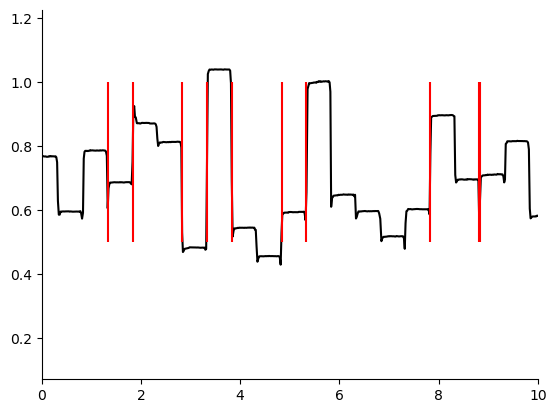

In [683]:
plt.plot(stim_time, stimcontrast, 'k')
plt.vlines(stim_onset_times, 0.5, 1, color='r')
plt.xlim([0,10])

In [572]:
stim_time[:-1][(np.diff(stimcontrast)>0)]

array([-9.69088000e-01, -9.33107000e-01, -8.99904000e-01, ...,
        1.21170137e+03,  1.21171739e+03,  1.21174957e+03])

(0.0, 3.0)

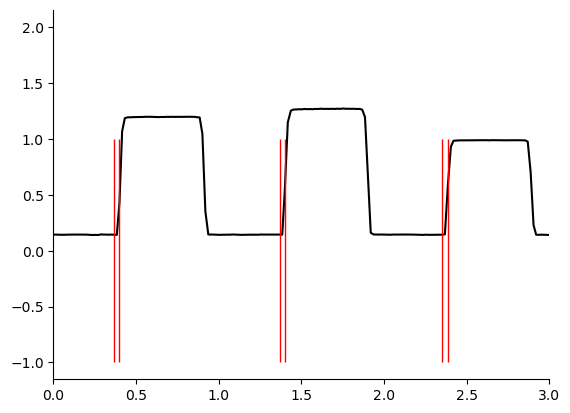

In [594]:
plt.plot(stim_time, stimcontrast, 'k')
plt.vlines(stim_time[:-2][np.diff(np.diff(stimcontrast)>0.2)], -1, 1, color='r', linewidth=1)
plt.xlim([0, 3])

In [596]:
_arr_test = np.diff(np.diff(stimcontrast)>0.2)[:30].copy()

In [599]:
_new_arr = []
for i in range(_arr_test.size):
    if (_arr_test[i-1]==True) and (_arr_test[i]==True):
        _new_arr.append(True)
    else:
        _new_arr.append(False)

In [584]:
_test = np.array([0,0,0,1,1,0,0,0,1,1,0,0,0])
np.diff(_test)

array([ 0,  0,  1,  0, -1,  0,  0,  1,  0, -1,  0,  0])

(0.0, 100.0)

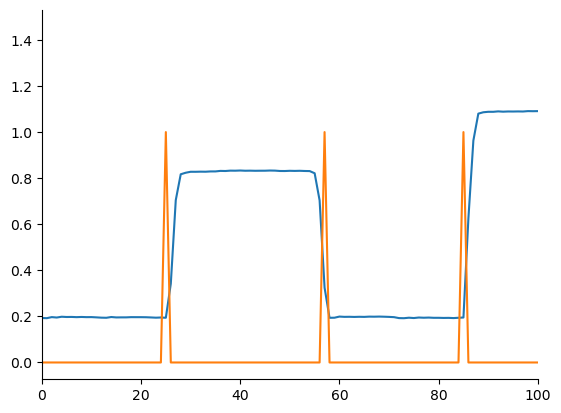

In [420]:
plt.plot(stimcontrast)
plt.plot(stim_on)
plt.xlim([0,100])

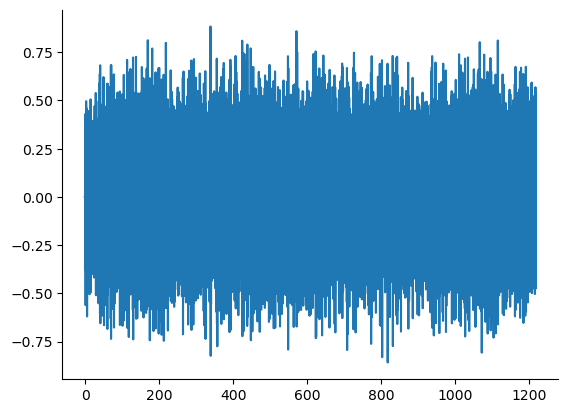

In [326]:
plt.plot(stim_time[:-1], np.diff(stimcontrast))
# plt.xlim([0,200])

In [233]:
stim_dT = []
for s in flhf['session'].unique():
    if len(flhf[flhf['hasSnR']==True][flhf['session']==s]) > 0:
        _stim_dT = np.diff(flhf['SnR_stimT_all_shared'][flhf['session']==s][flhf['hasSnR']==True])
        stim_dT.extend(_stim_dT)

In [ ]:




for count, name in enumerate(names):
    lpanel = light_panels[count]; dpanel = dark_panels[count]
    
    for x in ltdk['pref_gazeshift_psth'][ltdk['gazecluster']==name]:
        lpanel.plot(psth_bins, x, '-', linewidth=1, alpha=.3)
    lpanel.plot(psth_bins, np.nanmean(flatten_series(ltdk['pref_gazeshift_psth'][ltdk['gazecluster']==name][ltdk['gazeshift_responsive']==True]),0), '-', linewidth=3, color=cat_cmap[name])
    lpanel.set_xlim([-0.2,0.4]); lpanel.set_ylim([-1,1])
#     lpanel.set_title(name.capitalize())
    lpanel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    lpanel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
    
    for x in ltdk['pref_dark_gazeshift_psth'][ltdk['gazecluster']==name]:
        dpanel.plot(psth_bins, x, '-', linewidth=1, alpha=.3)
    dpanel.plot(psth_bins, np.nanmean(flatten_series(ltdk['pref_dark_gazeshift_psth'][ltdk['gazecluster']==name][ltdk['gazeshift_responsive']==True]),0), '-', linewidth=3, color=cat_cmap[name])
    dpanel.set_xlim([-0.2,0.4]); dpanel.set_ylim([-1,1])
    dpanel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    dpanel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
    
    if name=='early':
        lpanel.set_ylabel('norm. spike rate')
        # dpanel.set_ylabel('norm. spike rate')
    if name!='early':
        lpanel.set_yticklabels([])
        dpanel.set_yticklabels([])
    lpanel.set_xticklabels([])
    dpanel.set_xlabel('time (msec)')
    lpanel.set_title(name)
        
fig.savefig(os.path.join(figpath, '3_clustering.pdf'))
